In [ ]:
import numpy as np # linear algebra
import pandas as pd

In [ ]:
import tensorflow as tf
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, BatchNormalization, Flatten, Dropout, Activation, Input, Concatenate
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import optimizers
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping
from tensorflow.keras.datasets import cifar10
from tensorflow.keras.applications import efficientnet_v2, VGG16, ResNet50

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

import matplotlib.pyplot as plt

In [ ]:
seed = 2022
np.random.seed(seed)
tf.random.set_seed(seed)

In [ ]:
train_directory = "drive/MyDrive/Food_Grading2/train"
val_directory = "drive/MyDrive/Food_Grading2/val"
test_directory = "drive/MyDrive/Food_Grading2/test"

In [ ]:
train_datagen = ImageDataGenerator(rescale=1./255,rotation_range=15, width_shift_range=0.2, zoom_range=0.2, horizontal_flip=True)
test_datagen = ImageDataGenerator(rescale=1./255)

In [ ]:
train_generator = train_datagen.flow_from_directory(
train_directory,
target_size=(256,256),
color_mode='rgb',
batch_size=32,
class_mode='binary',
subset='training',
shuffle=True,
seed=42
)

Found 4804 images belonging to 2 classes.


In [ ]:
test_generator = test_datagen.flow_from_directory(
test_directory,
target_size=(256,256),
color_mode='rgb',
batch_size=32,
class_mode='binary',
shuffle=False
)

Found 1031 images belonging to 2 classes.


In [ ]:
val_generator = test_datagen.flow_from_directory(
val_directory,
target_size=(256,256),
color_mode='rgb',
batch_size=32,
class_mode='binary',
shuffle=False
)

Found 1030 images belonging to 2 classes.


In [ ]:
input_shape = (256, 256, 3) #Cifar10 image size
resized_shape = (224, 224, 3) #EfficientNetV2B0 model input shape
num_classes = 1

def build_model():
    inputs = Input(shape=input_shape)
    x = tf.keras.layers.Lambda(lambda image: tf.image.resize(image, resized_shape[:2]))(inputs) #Resize image to  size 224x224
    base_model = efficientnet_v2.EfficientNetV2S(include_top=False, input_shape=resized_shape, weights="imagenet")
    base_model.trainable = False
    x = base_model(x)
    x = GlobalAveragePooling2D()(x)
    x = Dropout(0.3)(x)
    outputs = Dense(num_classes, activation="sigmoid")(x)
    model = Model(inputs=inputs, outputs=outputs)
    return model

In [ ]:
model = build_model()

plateau = ReduceLROnPlateau(monitor="val_loss", factor=0.7, patience=1, verbose=1)
earlystopping = EarlyStopping(monitor="val_loss", patience=3, verbose=1)

model.compile(optimizer=optimizers.SGD(learning_rate=0.01, momentum=0.9),
              loss="binary_crossentropy",
              metrics=["accuracy"])

model.summary()
print("\n")

history = model.fit(train_generator,
                    epochs=25,
                    validation_data=val_generator,
                    callbacks=[plateau, earlystopping]
                   )


82420632/82420632 ━━━━━━━━━━━━━━━━━━━━ 5s 0us/step


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)             │ (None, 256, 256, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lambda (Lambda)                      │ (None, 224, 224, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ efficientnetv2-s (Functional)        │ (None, 7, 7, 1280)          │      20,331,360 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling2d             │ (None, 1280)                │               0 │
│ (GlobalAveragePooling2D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 1280)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 1)                   │           1,281 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 20,332,641 (77.56 MB)

 Trainable params: 1,281 (5.00 KB)

 Non-trainable params: 20,331,360 (77.56 MB)



Epoch 1/25


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


151/151 ━━━━━━━━━━━━━━━━━━━━ 2821s 18s/step - accuracy: 0.5464 - loss: 0.6852 - val_accuracy: 0.5767 - val_loss: 0.6659 - learning_rate: 0.0100
Epoch 2/25
151/151 ━━━━━━━━━━━━━━━━━━━━ 75s 473ms/step - accuracy: 0.5789 - loss: 0.6759 - val_accuracy: 0.6194 - val_loss: 0.6510 - learning_rate: 0.0100
Epoch 3/25
151/151 ━━━━━━━━━━━━━━━━━━━━ 74s 471ms/step - accuracy: 0.5918 - loss: 0.6678 - val_accuracy: 0.6456 - val_loss: 0.6458 - learning_rate: 0.0100
Epoch 4/25
151/151 ━━━━━━━━━━━━━━━━━━━━ 74s 470ms/step - accuracy: 0.6124 - loss: 0.6586 - val_accuracy: 0.6330 - val_loss: 0.6401 - learning_rate: 0.0100
Epoch 5/25
151/151 ━━━━━━━━━━━━━━━━━━━━ 74s 471ms/step - accuracy: 0.6138 - loss: 0.6529 - val_accuracy: 0.6660 - val_loss: 0.6344 - learning_rate: 0.0100
Epoch 6/25
151/151 ━━━━━━━━━━━━━━━━━━━━ 74s 471ms/step - accuracy: 0.6170 - loss: 0.6582 - val_accuracy: 0.6757 - val_loss: 0.6298 - learning_rate: 0.0100
Epoch 7/25
151/151 ━━━━━━━━━━━━━━━━━━━━ 75s 472ms/step - accuracy: 0.6225 - loss:

In [ ]:
print("Evaluate on test data")
results = model.evaluate(test_generator, batch_size=32)
print("test loss, test acc:", results)

Evaluate on test data
33/33 ━━━━━━━━━━━━━━━━━━━━ 783s 24s/step - accuracy: 0.8068 - loss: 0.5223
test loss, test acc: [0.6064860820770264, 0.67119300365448]


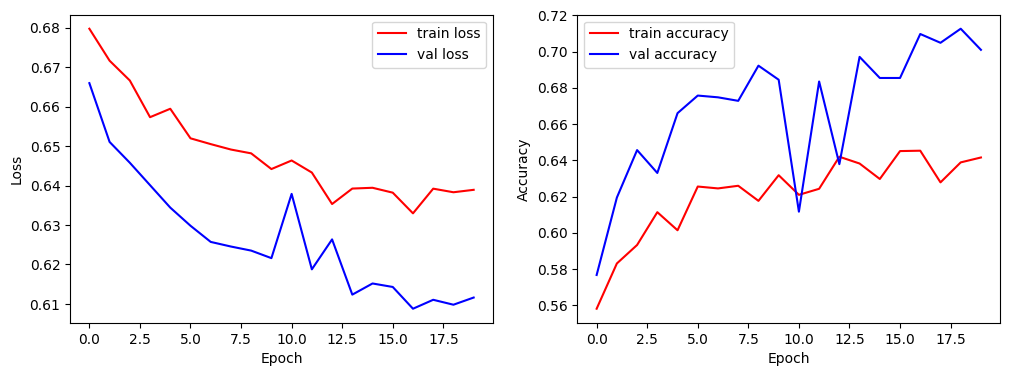

In [ ]:
fig, ax = plt.subplots(figsize=(12, 4), nrows=1, ncols=2)
ax[0].plot(history.history["loss"], c="r", label="train loss")
ax[0].plot(history.history["val_loss"], c="b", label="val loss")
ax[0].set_xlabel("Epoch")
ax[0].set_ylabel("Loss")
ax[0].legend()

ax[1].plot(history.history["accuracy"], c="r", label="train accuracy")
ax[1].plot(history.history["val_accuracy"], c="b", label="val accuracy")
ax[1].set_xlabel("Epoch")
ax[1].set_ylabel("Accuracy")
ax[1].legend()

In [ ]:
model.save('/content/drive/MyDrive/Efficientnet_V2S_Model.h5')